In [3]:
# Install OpenCV
!pip install opencv-python

Saving 000000407646.jpg to 000000407646.jpg
Uploaded file: 000000407646.jpg


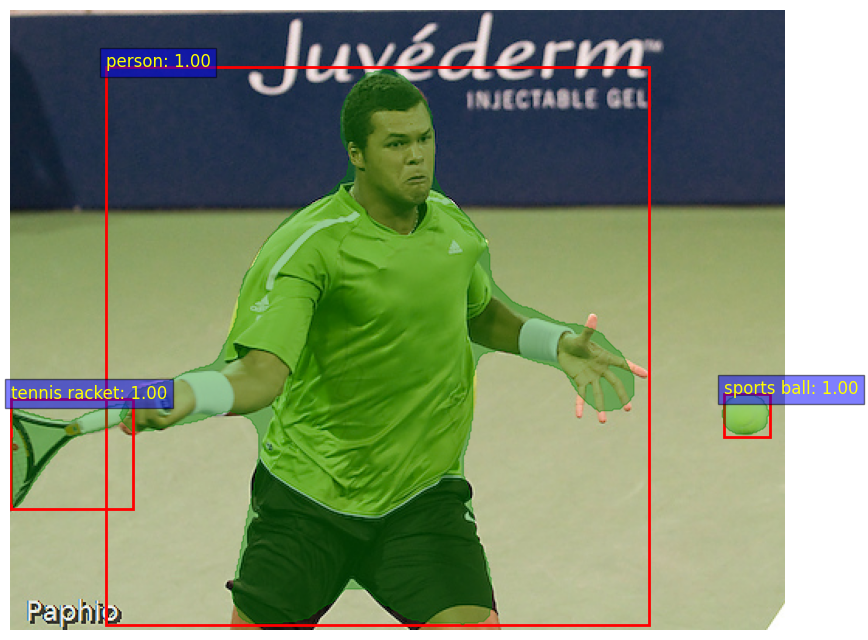

In [5]:
# Install OpenCV
!pip install opencv-python

import torch
import torchvision
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2  # Import OpenCV
from google.colab import files
from matplotlib.patches import Polygon

# Check for CUDA availability
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load a pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.COCO_V1)
model.to(device)
model.eval()  # Switch to evaluation mode

# Image transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# COCO Class Names (only the relevant ones)
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
    'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
    'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant',
    'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]

# Function to visualize results
def plot_image_with_annotations(image, boxes, masks, labels, scores, threshold=0.5):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for box, mask, label, score in zip(boxes, masks, labels, scores):
        if score < threshold:
            continue

        # Bounding box
        x1, y1, x2, y2 = box
        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, fill=False, color="red", linewidth=2
        )
        ax.add_patch(rect)

        # Label with score
        ax.text(
            x1, y1, f"{label}: {score:.2f}", fontsize=12, color="yellow", bbox=dict(facecolor="blue", alpha=0.5)
        )

        # Mask overlay
        mask = mask[0] > 0.5  # Binary thresholding
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            polygon = Polygon(contour.reshape(-1, 2), fill=True, color="green", alpha=0.4)
            ax.add_patch(polygon)

    plt.axis("off")
    plt.show()

# Upload an image
uploaded = files.upload()
image_path = next(iter(uploaded.keys()))  # Get the uploaded file name
print(f"Uploaded file: {image_path}")

# Load and process the uploaded image
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    predictions = model(image_tensor)

# Extract predictions
boxes = predictions[0]['boxes'].cpu().numpy()
masks = predictions[0]['masks'].cpu().numpy()
labels = predictions[0]['labels'].cpu().numpy()
scores = predictions[0]['scores'].cpu().numpy()

# Map labels to class names
label_names = [COCO_INSTANCE_CATEGORY_NAMES[label] for label in labels]

# Visualize the detected objects with annotations
plot_image_with_annotations(
    np.array(image),
    boxes,
    masks,
    label_names,
    scores,
    threshold=0.5
)
